<a href="https://colab.research.google.com/github/Ariiiff/NLP_Practices/blob/main/bengali_hate_speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import itertools
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.models import Sequential,Model
from keras.layers import Dense,LSTM, SpatialDropout1D, Embedding
from keras.utils import to_categorical
from joblib import dump, load


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Reading the test dataset
test_df = pd.read_csv('/content/gdrive/MyDrive/NLP/Project/Bangali-hate-speech-detection/Datasets/test.csv')

# Reading the train dataset
train_df = pd.read_csv('/content/gdrive/MyDrive/NLP/Project/Bangali-hate-speech-detection/Datasets/train.csv')


# Reading the test dataset
val_df = pd.read_csv('/content/gdrive/MyDrive/NLP/Project/Bangali-hate-speech-detection/Datasets/validate.csv')
# val_text = val_df['text'].tolist()
# val_label = val_df['label'].tolist()


In [4]:
dfs = [train_df, test_df, val_df]
#merge all DataFrames into one
final_df = pd.concat(dfs)

In [5]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4500 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4500 non-null   object
 1   label   4500 non-null   object
dtypes: object(2)
memory usage: 105.5+ KB


In [6]:
final_df

,text,label
0,ধর্মীয় বইগুলোকে বলা হচ্ছে উগ্রবাদী বই।,Religious
1,দাদা! নৌকা কিন্তু চলে না। এমাসে কম দিয়েছেন ১৯ ...,Geopolitical
2,"দম্ভ ও অহংকার পতনের মূল, জাতি দম্ভ দেখেছে এখন ...",Geopolitical
3,বিএনপি জামাতের আগুন সন্ত্রাস। রাজধানীতে বাসে আ...,Geopolitical
4,পুলিশকে ২০ দলের হুশিয়ারী বেশি বাড়াবাড়ি করলে তা...,Geopolitical
...,...,...
895,"নায়ক যখন অনেক গরীব, কিন্তু নাইকার বাবা অনেক ধনী।",Neutral
896,"পৃথিবীতে একটাই সমস্যা, সেটা হলো বউ। কেউ নিয়ে আ...",Neutral
897,"আমাদের কাহিনীর মধ্যে ভুত, আমার দিকে একটু ফোকাস...",Neutral
898,"কয়েক মিনিট পর পর রবি কোম্পানি, তোর কি ইন্টারনে...",Neutral


In [7]:
pd.unique(final_df['label'])

array(['Religious', 'Geopolitical', 'Neutral', 'Personal', 'Political'],
      dtype=object)

In [8]:
def label_classification(value) :
  if value == 'Neutral':
        return 0
  if value == "Religious":
        return 1
  elif value == 'Geopolitical':
        return 2
  elif value == 'Personal':
        return 3
  elif value == 'Political':
        return 4

In [9]:
final_df['class'] = final_df['label'].map(label_classification)

In [10]:
final_df

,text,label,class
0,ধর্মীয় বইগুলোকে বলা হচ্ছে উগ্রবাদী বই।,Religious,1
1,দাদা! নৌকা কিন্তু চলে না। এমাসে কম দিয়েছেন ১৯ ...,Geopolitical,2
2,"দম্ভ ও অহংকার পতনের মূল, জাতি দম্ভ দেখেছে এখন ...",Geopolitical,2
3,বিএনপি জামাতের আগুন সন্ত্রাস। রাজধানীতে বাসে আ...,Geopolitical,2
4,পুলিশকে ২০ দলের হুশিয়ারী বেশি বাড়াবাড়ি করলে তা...,Geopolitical,2
...,...,...,...
895,"নায়ক যখন অনেক গরীব, কিন্তু নাইকার বাবা অনেক ধনী।",Neutral,0
896,"পৃথিবীতে একটাই সমস্যা, সেটা হলো বউ। কেউ নিয়ে আ...",Neutral,0
897,"আমাদের কাহিনীর মধ্যে ভুত, আমার দিকে একটু ফোকাস...",Neutral,0
898,"কয়েক মিনিট পর পর রবি কোম্পানি, তোর কি ইন্টারনে...",Neutral,0


In [11]:
new_df = final_df.dropna()

In [12]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4500 entries, 0 to 899
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4500 non-null   object
 1   label   4500 non-null   object
 2   class   4500 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 140.6+ KB


In [13]:
#cleaning
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)

    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [14]:
clean_texts = []
for txt in new_df["text"] :
  clean_texts.append(preprocessing(txt))


In [15]:
data1 = pd.read_excel('/content/gdrive/MyDrive/NLP/Project/Bangali-hate-speech-detection/Datasets/stopwords_bangla.xlsx')
stopwords = data1['words'].tolist()

In [16]:
def stopwordRemoval(text):
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stopwords]

    out=' '.join(stm)

    return str(out)

In [17]:
new_clean_texts = []
for txt in clean_texts :
  new_clean_texts.append(stopwordRemoval(txt))

In [18]:
new_clean_texts[: 10]

['ধর্মীয় বইগুলোকে উগ্রবাদী বই',
 'দাদা নৌকা না এমাসে কিউসেক পানি নদীতে পানির দরকার বন্ধুত্বে জোয়ার বইছে',
 'দম্ভ অহংকার পতনের মূল জাতি দম্ভ দেখেছে পতন',
 'বিএনপি জামাতের আগুন সন্ত্রাস রাজধানীতে বাসে আগুন দেয়ার ঘাঁনয় বিএনপি জামাতের আটক',
 'পুলিশকে দলের হুশিয়ারী বাড়াবাড়ি বাড়ীতে বাড়ীতে আক্রমন',
 'চুইংগাম চিবানোর সময় পাকস্থলিও কনফিউজড যায় ঘন্টা চিবুচ্ছে না',
 'পি আসার রাগের মাথায় নুনু তে কয়ডা থাপ্পর মারলাম',
 'গ্রাম এসেই চাচাতো ভাই চুরি আব্বু চাচাতো ভাই',
 'আনুশকা দিহানের গোপন ভিডিও মামুনুল হক বললো দেখুন ভিডিওতে',
 'ব্যাচেলর ছেলেকে বাসার ছাদে বালতি ভেজা কাপড় শুকাতে দেখার']

In [19]:
new_df['clean_text'] = new_clean_texts

In [20]:
new_df

,text,label,class,clean_text
0,ধর্মীয় বইগুলোকে বলা হচ্ছে উগ্রবাদী বই।,Religious,1,ধর্মীয় বইগুলোকে উগ্রবাদী বই
1,দাদা! নৌকা কিন্তু চলে না। এমাসে কম দিয়েছেন ১৯ ...,Geopolitical,2,দাদা নৌকা না এমাসে কিউসেক পানি নদীতে পানির দরক...
2,"দম্ভ ও অহংকার পতনের মূল, জাতি দম্ভ দেখেছে এখন ...",Geopolitical,2,দম্ভ অহংকার পতনের মূল জাতি দম্ভ দেখেছে পতন
3,বিএনপি জামাতের আগুন সন্ত্রাস। রাজধানীতে বাসে আ...,Geopolitical,2,বিএনপি জামাতের আগুন সন্ত্রাস রাজধানীতে বাসে আগ...
4,পুলিশকে ২০ দলের হুশিয়ারী বেশি বাড়াবাড়ি করলে তা...,Geopolitical,2,পুলিশকে দলের হুশিয়ারী বাড়াবাড়ি বাড়ীতে বাড়ীতে আ...
...,...,...,...,...
895,"নায়ক যখন অনেক গরীব, কিন্তু নাইকার বাবা অনেক ধনী।",Neutral,0,নায়ক গরীব নাইকার বাবা ধনী
896,"পৃথিবীতে একটাই সমস্যা, সেটা হলো বউ। কেউ নিয়ে আ...",Neutral,0,পৃথিবীতে একটাই সমস্যা বউ আসার কাঁদছে কাঁদছে
897,"আমাদের কাহিনীর মধ্যে ভুত, আমার দিকে একটু ফোকাস...",Neutral,0,কাহিনীর ভুত একটু ফোকাস দিও
898,"কয়েক মিনিট পর পর রবি কোম্পানি, তোর কি ইন্টারনে...",Neutral,0,মিনিট রবি কোম্পানি তোর ইন্টারনেট অফার লাগবে


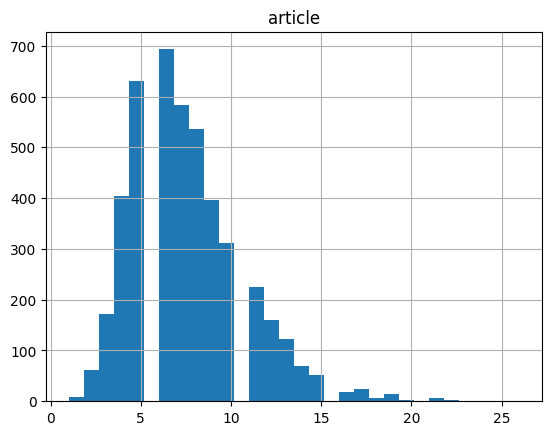

In [22]:
import matplotlib.pyplot as plt
text_word_count = []
text_word_count = []

# populate the lists with sentence lengths
for i in new_df['clean_text'] :
      text_word_count.append(len(i.split()))

length_df = pd.DataFrame({'article':text_word_count})
length_df.hist(bins = 30)
plt.show()

In [23]:
print("max word in text : ", max(text_word_count))
print("min word in text : ", min(text_word_count))

max word in text :  26
min word in text :  1


In [48]:
clean_texts = new_df['clean_text'].tolist()
cls = new_df['class'].tolist()

In [49]:
#Splitting the dataset into test and validation
max_len_txt = 26
X_train, X_test, y_train, y_test = train_test_split(new_df['clean_text'], new_df['class'], test_size=0.2, random_state=42)

In [50]:
word2vec = {}
with open('/content/gdrive/MyDrive/Bangla_News_Article_Dataset/bn_glove.39M.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

In [51]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [52]:
## Tokenizing -> basically we use tokenisation for many things, its commonly used for feature extraction in preprocessing. btw idk how it works as feature extraction tho :(
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
word2idx = tokenizer.word_index
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

## Padding -> to uniform the datas
X_train = pad_sequences(X_train, maxlen = max_len_txt, padding='post')
X_test = pad_sequences(X_test, maxlen = max_len_txt, padding='post')

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [53]:
embedding_dim = len(next(iter(word2vec.values())))

In [54]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [64]:
# Assuming y_train and y_test are integer class labels
num_classes = 5  # Number of classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Dot, Activation, Reshape
import tensorflow as tf

In [95]:
# Bidirectional LSTM model architecture with attention mechanism
inputs = tf.keras.Input(shape=(max_len_txt,))
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_len_txt, weights=[embedding_matrix], trainable=False)(inputs)
bidirectional_lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
attention_weights = Dense(1, activation='tanh')(bidirectional_lstm)
attention_weights = Activation('softmax')(attention_weights)
attention_weights = Reshape((-1,))(attention_weights)  # Reshape to match LSTM output shape
context_vector = Dot(axes=1)([attention_weights, bidirectional_lstm])
dropout = Dropout(0.5)(context_vector)
dense1 = Dense(128, activation="relu")(dropout)
dropout2 = Dropout(0.5)(dense1)
outputs = Dense(5, activation="softmax")(dropout2)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [96]:
# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=10,
    validation_data=(X_test, y_test)
)



Epoch 1/10
57/57 [==============================] - 11s 110ms/step - loss: 1.5081 - accuracy: 0.4333 - val_loss: 1.0283 - val_accuracy: 0.5778
Epoch 2/10
57/57 [==============================] - 4s 78ms/step - loss: 1.1226 - accuracy: 0.5286 - val_loss: 0.9543 - val_accuracy: 0.6233
Epoch 3/10
57/57 [==============================] - 6s 110ms/step - loss: 1.0026 - accuracy: 0.5783 - val_loss: 0.9145 - val_accuracy: 0.6222
Epoch 4/10
57/57 [==============================] - 4s 78ms/step - loss: 0.9477 - accuracy: 0.5989 - val_loss: 0.9004 - val_accuracy: 0.6411
Epoch 5/10
57/57 [==============================] - 4s 79ms/step - loss: 0.8918 - accuracy: 0.6331 - val_loss: 0.8949 - val_accuracy: 0.6344
Epoch 6/10
57/57 [==============================] - 6s 106ms/step - loss: 0.8570 - accuracy: 0.6411 - val_loss: 0.8875 - val_accuracy: 0.6567
Epoch 7/10
57/57 [==============================] - 6s 99ms/step - loss: 0.8015 - accuracy: 0.6578 - val_loss: 0.8842 - val_accuracy: 0.6611
Epoch 8/1

In [97]:
# Example text to predict
example_txt = 'ধর্মীয় বইগুলোকে বলা হচ্ছে উগ্রবাদী বই।'

pre_exm_txt = preprocessing(example_txt)


final_txt = (stopwordRemoval(pre_exm_txt))

# Preprocess and predict
test_seq = tokenizer.texts_to_sequences([final_txt])
test_seq = pad_sequences(test_seq, maxlen=max_len_txt)
prediction = model.predict(test_seq)

# Output prediction
predicted_class = np.argmax(prediction)
class_labels = ['Neutral', 'Religious Hate Speech', 'Political Hate Speech', 'Personal Hate Speech']
print("Predicted Class:", class_labels[predicted_class])

1/1 [==============================] - 1s 872ms/step
Predicted Class: Religious Hate Speech


In [98]:
# Example text to predict
example_txt = 'কুত্তার বাচ্চা পাপন'

pre_exm_txt = preprocessing(example_txt)


final_txt = (stopwordRemoval(pre_exm_txt))

# Preprocess and predict
test_seq = tokenizer.texts_to_sequences([final_txt])
test_seq = pad_sequences(test_seq, maxlen=max_len_txt)
prediction = model.predict(test_seq)

# Output prediction
predicted_class = np.argmax(prediction)
class_labels = ['Neutral', 'Religious Hate Speech', 'Political Hate Speech', 'Personal Hate Speech']
print("Predicted Class:", class_labels[predicted_class])

1/1 [==============================] - 0s 26ms/step
Predicted Class: Personal Hate Speech


In [103]:
# Example text to predict
example_txt = 'আমি পাকিস্তান এর সাথে জড়িত'

pre_exm_txt = preprocessing(example_txt)


final_txt = (stopwordRemoval(pre_exm_txt))

# Preprocess and predict
test_seq = tokenizer.texts_to_sequences([final_txt])
test_seq = pad_sequences(test_seq, maxlen=max_len_txt)
prediction = model.predict(test_seq)

# Output prediction
predicted_class = np.argmax(prediction)
class_labels = ['Neutral', 'Religious Hate Speech', 'Political Hate Speech', 'Personal Hate Speech']
print("Predicted Class:", class_labels[predicted_class])

1/1 [==============================] - 0s 43ms/step
Predicted Class: Neutral


In [102]:
# Example text to predict
example_txt = 'তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব'

pre_exm_txt = preprocessing(example_txt)


final_txt = (stopwordRemoval(pre_exm_txt))

# Preprocess and predict
test_seq = tokenizer.texts_to_sequences([final_txt])
test_seq = pad_sequences(test_seq, maxlen=max_len_txt)
prediction = model.predict(test_seq)

# Output prediction
predicted_class = np.argmax(prediction)
class_labels = ['Neutral', 'Religious Hate Speech', 'Political Hate Speech', 'Personal Hate Speech']
print("Predicted Class:", class_labels[predicted_class])

1/1 [==============================] - 0s 25ms/step
Predicted Class: Personal Hate Speech
